In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

Number of Training Images Before Augmentation:
Parasitized: 13780
Uninfected: 13780

Number of Testing Images Before Augmentation:
Parasitized: 7952
Uninfected: 7880


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


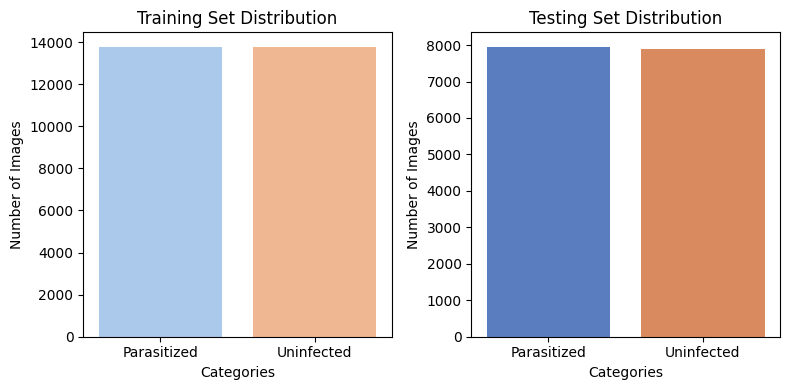

Sample Image Shape (Before Augmentation): (151, 130, 3)


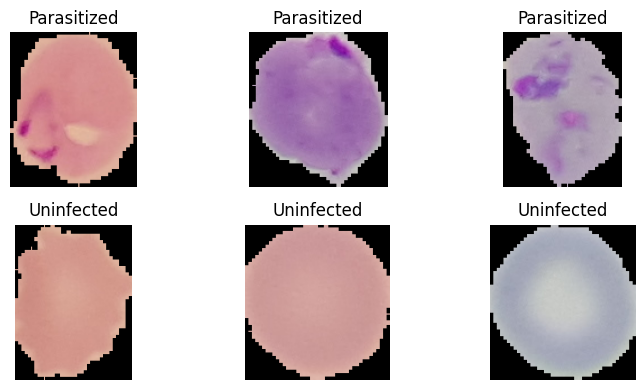

In [12]:
# Define paths
my_data_dir = '../input/files1/Malaria Cells'
train_path = my_data_dir + '/training_set'
test_path = my_data_dir + '/testing_set'

# Dataset Distribution Visualization
categories = ['Parasitized', 'Uninfected']
train_counts = [len(os.listdir(os.path.join(train_path, cat))) for cat in categories]
test_counts = [len(os.listdir(os.path.join(test_path, cat))) for cat in categories]

print("Number of Training Images Before Augmentation:")
for category, count in zip(categories, train_counts):
    print(f"{category}: {count}")

print("\nNumber of Testing Images Before Augmentation:")
for category, count in zip(categories, test_counts):
    print(f"{category}: {count}")

# Plot train and test distribution
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=categories, y=train_counts, palette='pastel')
plt.title("Training Set Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Categories")

plt.subplot(1, 2, 2)
sns.barplot(x=categories, y=test_counts, palette='muted')
plt.title("Testing Set Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Categories")

plt.tight_layout()
plt.show()

# Image shape before augmentation
sample_image_path = os.path.join(train_path, 'Parasitized', os.listdir(os.path.join(train_path, 'Parasitized'))[0])
sample_image = imread(sample_image_path)
print("Sample Image Shape (Before Augmentation):", sample_image.shape)

# Display 6 samples from the original dataset (before augmentation)
def display_sample_images(image_dir, categories, num_samples=6):
    plt.figure(figsize=(8, 4))
    for i, category in enumerate(categories):
        # Get the list of images in the category
        image_paths = os.listdir(os.path.join(image_dir, category))
        # Randomly select image paths
        sample_paths = np.random.choice(image_paths, num_samples // len(categories), replace=True)    
        for j, image_path in enumerate(sample_paths):
            img = imread(os.path.join(image_dir, category, image_path))
            plt.subplot(len(categories), num_samples // len(categories), i * (num_samples // len(categories)) + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{category}")
    plt.tight_layout()
    plt.show()

# Display 6 samples
display_sample_images(train_path, categories)


In [13]:
# Data Augmentation
image_shape = (224, 224, 3)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 27558 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


In [14]:
# Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load and Fine-Tune EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=image_shape)

# Fine-tune by unfreezing the last 120 layers
for layer in base_model.layers[-120:]:
    layer.trainable = True

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.008)),
    Dropout(0.4),  # Adjusted dropout to avoid overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.008)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Force building the model to ensure the summary is correct
model.build(input_shape=(None,) + image_shape)
# Display the model summary
print("Model Summary:")
base_model.summary()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,221,860 (16.11 MB)

 Trainable params: 4,179,837 (15.94 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/52


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 658s 673ms/step - accuracy: 0.6969 - loss: 3.0346 - val_accuracy: 0.9372 - val_loss: 2.5002 - learning_rate: 1.0000e-05
Epoch 2/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 334s 385ms/step - accuracy: 0.9429 - loss: 2.3707 - val_accuracy: 0.9344 - val_loss: 2.1244 - learning_rate: 1.0000e-05
Epoch 3/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 335s 385ms/step - accuracy: 0.9503 - loss: 2.0151 - val_accuracy: 0.9403 - val_loss: 1.7908 - learning_rate: 1.0000e-05
Epoch 4/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 334s 385ms/step - accuracy: 0.9544 - loss: 1.6977 - val_accuracy: 0.9390 - val_loss: 1.5044 - learning_rate: 1.0000e-05
Epoch 5/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 330s 380ms/step - accuracy: 0.9539 - loss: 1.4221 - val_accuracy: 0.9394 - val_loss: 1.2576 - learning_rate: 1.0000e-05
Epoch 6/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 332s 382ms/step - accuracy: 0.9607 - loss: 1.1724 - val_accuracy: 0.9381 - val_loss: 1.0460 - learning_rate: 1.0000e-05
Epoch 7/52
862/862 ━━━━━━━━━━━━━━━━━━━━ 334s 385ms/

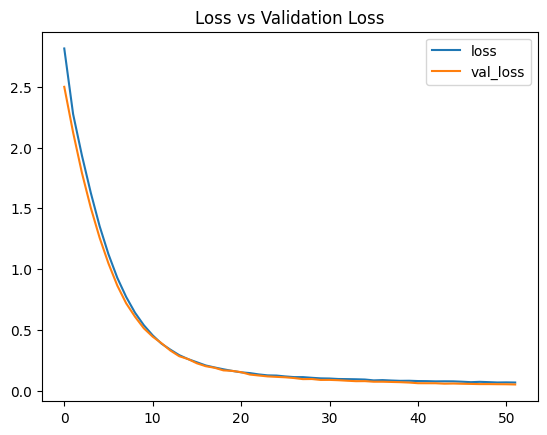

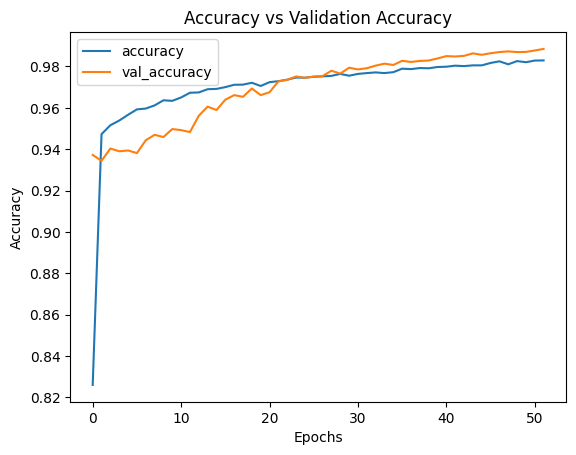

In [15]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Slightly lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='my_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=52,
    validation_data=test_generator,
    callbacks=[early_stop, lr_reduce, model_checkpoint],  # Added ModelCheckpoint
    class_weight=class_weights  
)
model.save('my_model.keras')
# Plot training and validation loss
losses = pd.DataFrame(history.history)
losses[['loss', 'val_loss']].plot(title='Loss vs Validation Loss')

# Plot training and validation accuracy
losses[['accuracy', 'val_accuracy']].plot(title='Accuracy vs Validation Accuracy', ylabel='Accuracy', xlabel='Epochs')
# Evaluate the model
results = model.evaluate(test_generator)
test_loss = results[0]
test_accuracy = results[1]
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

495/495 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7952
           1       0.99      0.99      0.99      7880

    accuracy                           0.99     15832
   macro avg       0.99      0.99      0.99     15832
weighted avg       0.99      0.99      0.99     15832

Confusion Matrix:


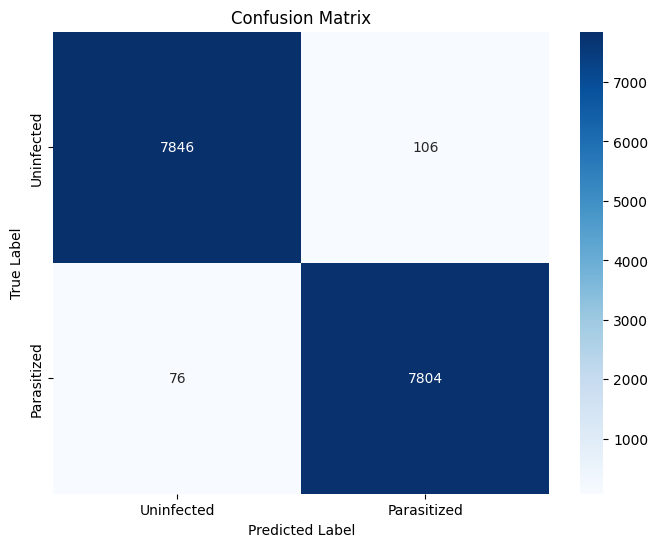

In [16]:
# Predictions and Evaluation
pred_probabilities = model.predict(test_generator)
predictions = (pred_probabilities > 0.5).astype(int)

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(test_generator.classes, predictions))

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, predictions)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

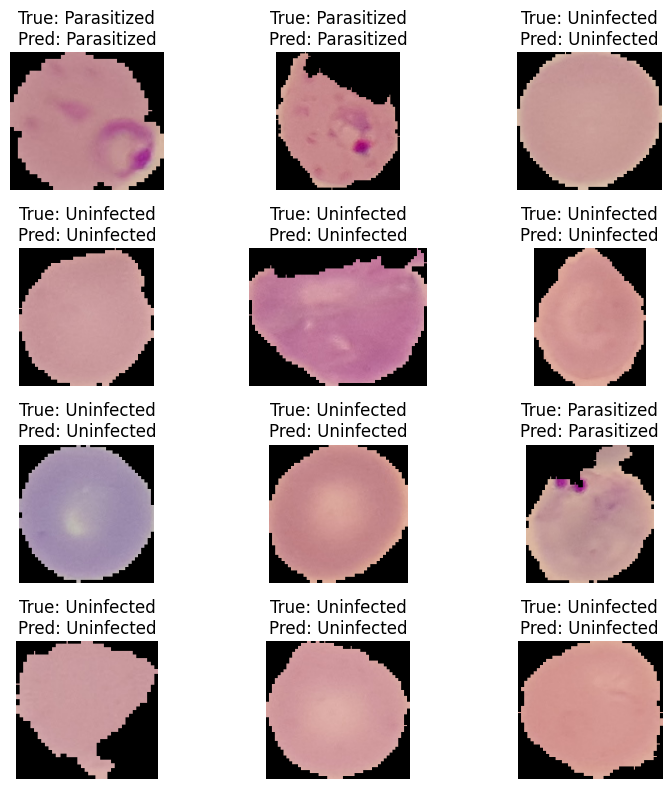

In [17]:
# Display 12 random test images with true and predicted labels
def display_random_test_images(generator, predictions, num_samples=12):
    # Get the indices of the random samples
    random_indices = np.random.choice(len(generator.filenames), num_samples, replace=False)
    
    plt.figure(figsize=(8, 8))
    
    for i, idx in enumerate(random_indices):
        # Get the true label
        true_label = generator.classes[idx]
        # Get the predicted label
        predicted_label = predictions[idx]
        # Get the image path
        img_path = generator.filenames[idx]
        # Load the image
        img = imread(os.path.join(generator.directory, img_path))
        
        # Plot the image
        plt.subplot(4, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {'Parasitized' if true_label == 0 else 'Uninfected'}\nPred: {'Parasitized' if predicted_label == 0 else 'Uninfected'}")
    
    plt.tight_layout()
    plt.show()

# Display 6 random test images with their true and predicted labels
display_random_test_images(test_generator, predictions)


In [18]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

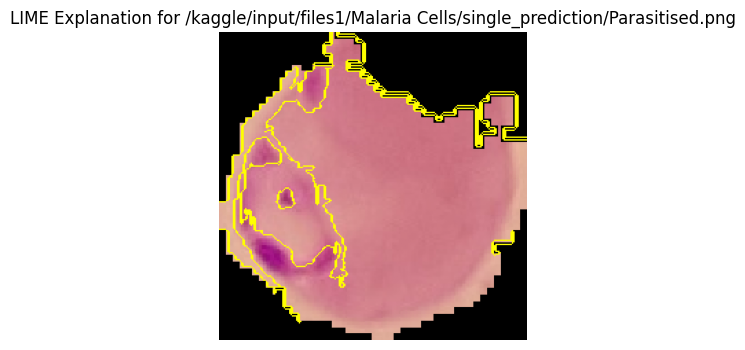

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

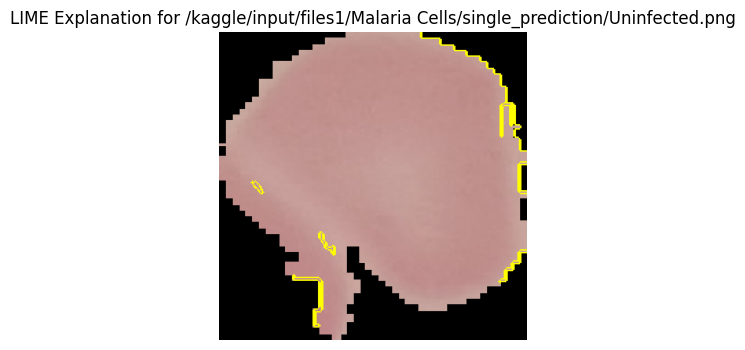

In [19]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=2000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation for {image_path}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/single_prediction/Parasitised.png',
    '/kaggle/input/files1/Malaria Cells/single_prediction/Uninfected.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

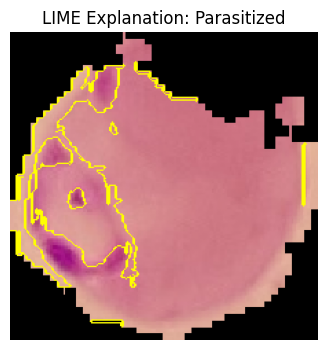

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

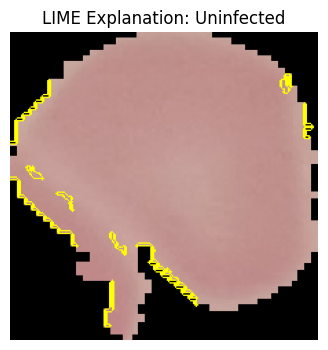

In [37]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/single_prediction/Parasitised.png',
    '/kaggle/input/files1/Malaria Cells/single_prediction/Uninfected.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

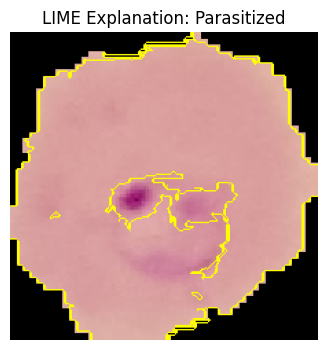

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

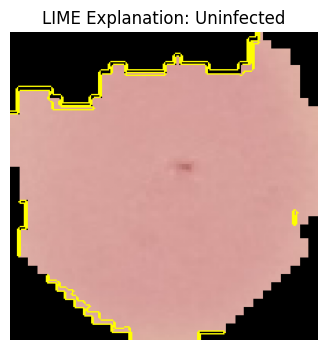

In [20]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

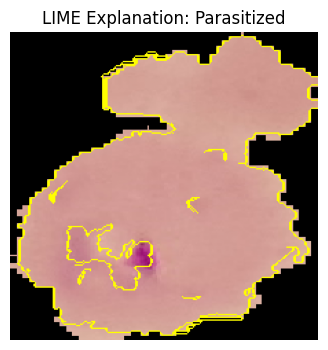

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

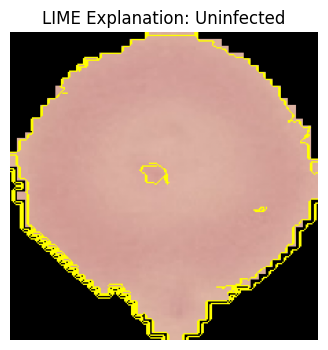

In [21]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_25.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

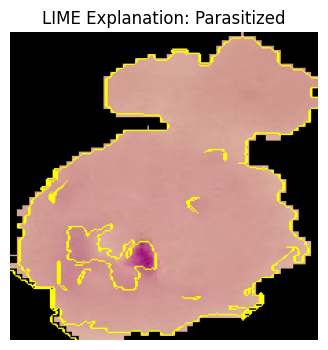

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

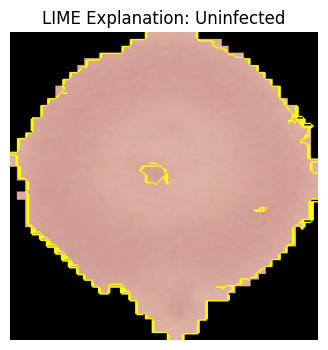

In [24]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_25.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

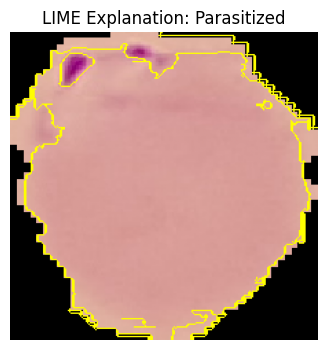

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

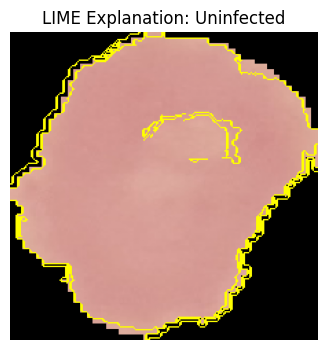

In [25]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_108.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

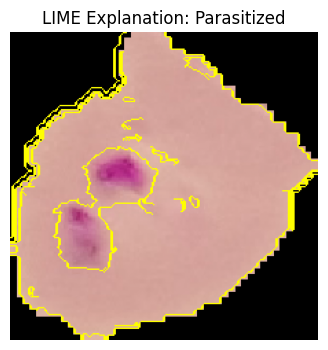

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

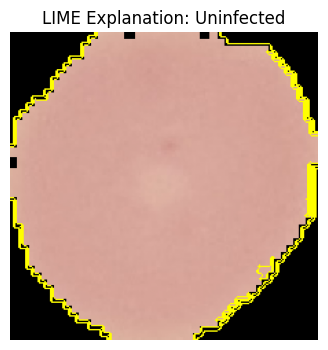

In [26]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_120.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

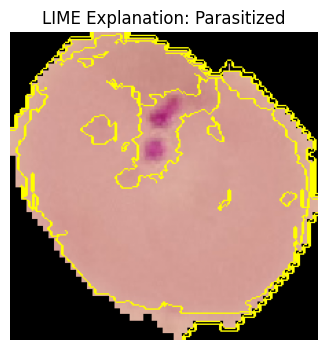

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

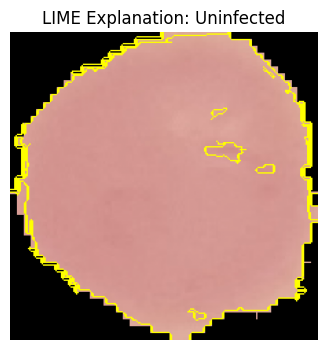

In [29]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_131.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

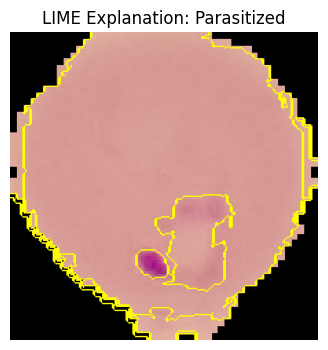

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

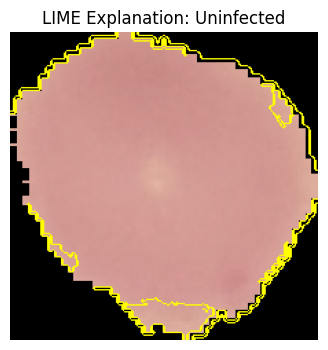

In [31]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, image_paths, class_names=['Parasitized', 'Uninfected']):
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)
            
            # Check model's prediction for the image
            prediction = model.predict(img_array)
            predicted_class = int(prediction[0][0] > 0.5)  # Binary classification threshold

            # Convert back to uint8 for LIME
            img_uint8 = np.uint8(img_array[0] * 255)  

            # Define LIME explainer
            explainer = lime.lime_image.LimeImageExplainer()
            
            # Define a prediction function
            def predict_fn(images):
                return model.predict(np.array(images))

            # Explain the image
            explanation = explainer.explain_instance(
                img_uint8, 
                predict_fn, 
                top_labels=2, 
                hide_color=0, 
                num_samples=3000,  # More perturbations
                segmentation_fn=lime.lime_image.SegmentationAlgorithm('felzenszwalb', scale=100)  # Better segmentation
            )

            # Check if top_labels is not empty
            if not explanation.top_labels:
                print(f"LIME could not generate explanations for image: {image_path}. Check the model's predictions or input image.")
                continue

            # Get the superpixels contributing to the prediction
            temp, mask = explanation.get_image_and_mask(
                label=explanation.top_labels[0],
                positive_only=True,
                num_features=10,  # Show more regions
                hide_rest=False   # Keep unimportant parts visible
            )

            # Set the predicted class to "Unknown" if it's not in the class_names list
            predicted_class_name = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

            # Plot the explanation with the predicted class in the title
            plt.figure(figsize=(4, 4))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f'LIME Explanation: {predicted_class_name}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred for image {image_path}: {e}")
            print("Check the input image path, model predictions, or LIME configuration.")

# Test with two sample images
image_paths = [
    '/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png',
    '/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_40.png'
]  # Replace with the paths to your images
explain_with_lime(model, image_paths)
